# Influenza Competition model 1.2
Same concept as comp model 1 but more efficient. 
Some key differences:
- No back mutation
- No sequence information using array. Only keeps track of mutant allele amount

In [1]:
import numpy as np

class Virus1():
    """
    This class produces objects which are single agents of a influenza virus with 1 segment.
    k = number of deleterious mutation in entire genome
    s = fitness decrease from deleterious mutation
    L = sequence length for a virus
    cost = cost of having multisegments
    w = fitness
    """
    def __init__(self,k):
        self.k = k
        self.w = (1 - s)**self.k
    
    def mutate(self,mu):
        """
        Mutation in sequence before reproduction
        mu = mutation rate
        """
        mut_num = int(np.random.binomial(L, mu)) # number of mutation
        for i in range(mut_num):
            if np.random.uniform(0,L) < self.k:
                self.k -= 1 # back mutation
            else:
                self.k += 1 # normal mutation
                
                
class Virus2():
    """
    This class produces objects which are single agents of a influenza virus with 2 segments.
    k1 = number of deleterious mutation in segment1
    k2 = number of deleterious mutation in segment2
    k = number of deleterious mutation in entire genome
    cost = cost of having multisegments
    w = fitness
    progeny_n = number of progenies a virus agent will have during reproduction. Default is 0.
    """
    def __init__(self,k1, k2):
        self.k1 = k1
        self.k2 = k2
        self.k = self.k1 + self.k2
        self.progeny_n = 0
        self.w = (1 - s)**self.k - cost
    
    def mutate(self,mu):
        """
        Mutation in sequence before reproduction
        mu = mutation rate
        """
        mut_num = int(np.random.binomial(L, mu)) # number of mutation
        for i in range(mut_num):
            p = np.random.uniform(0,1)
            if np.random.uniform(0,L) < self.k: # back mutation
                if p < 0.5: # seg1
                    self.k1 -= 1
                    self.k -= 1
                else: # seg2
                    self.k2 -= 1
                    self.k -= 1
            else: # normal mutation
                if p < 0.5: # seg1
                    self.k1 += 1
                    self.k += 1
                else: # seg2
                    self.k2 += 1
                    self.k += 1


In [ ]:
np.random9

In [38]:
def reproduce(viruses1, viruses2):
    """
    input
        viruses1 = array of 1segmented virus agents.
        viruses2 = array of multi-segmented virus agents.
    output
        next_gen1 = array of 1segemented virus of next generation.
        next_gen2 = array of multi-segemented virus of next generation.
    """
    next_gen1 = []
    next_gen2 = []
    
    for i in range(len(viruses1)): # reproduction of 1segs
        progeny_n = np.random.poisson(viruses1[i].w*(2/(1+N/K))) # number of progeny for that virus
        for j in range(progeny_n):
            next_gen1.append(Virus1(viruses1[i].k))
            
    remaining = [] # virus parents with remaining progenies to reproduce (for multi-segs)
    for i in range(len(viruses2)): # reproduction of multi-segs
        viruses2[i].progeny_n = np.random.poisson(viruses2[i].w*(2/(1+N/K)))
        if viruses2[i].progeny_n > 0:
            remaining.append(i)
    while len(remaining) >= 2: # while there's at least 2 remaining viruses to reproduce together
        samp = sorted(np.random.choice(remaining, 2, replace=False)) # pick 2 from the remaining
        offspring1, offspring2 = reassort(viruses2[samp[0]], viruses2[samp[1]])
        next_gen2.append(offspring1)
        next_gen2.append(offspring2)
        viruses2[samp[0]].progeny_n -= 1
        viruses2[samp[1]].progeny_n -= 1
        if viruses2[samp[0]].progeny_n == 0: # remove index from remaining if progeny_n is 0.
            del remaining[np.where(np.array(remaining)==samp[0])[0][0]]
        if viruses2[samp[1]].progeny_n == 0:
            del remaining[np.where(np.array(remaining)==samp[1])[0][0]]
    # when there's only 1 index reamining, go through regular reproduction (no reassortment)
    for i in remaining:
        for j in range(viruses2[i].progeny_n):
            next_gen2.append(Virus2(viruses2[i].k1, viruses2[i].k2))
    return next_gen1, next_gen2

In [39]:
def reassort(v1, v2):
    prob = np.random.uniform(0,1)
    if prob < r: # reassortment
        offspring1 = Virus2(v1.k1, v2.k2) # v1 gives first segment
        offspring2 = Virus2(v2.k1, v1.k2) # v2 gives first segment
        return offspring1, offspring2
    else: # no reassortment
        offspring1 = Virus2(v1.k1,v1.k2)
        offspring2 = Virus2(v2.k1,v2.k2)
        return offspring1, offspring2

### Parameters
* L = sequence length for a virus
* N = Population size (N0 = initial population)
* K = Carrying capacity
* s = fitness decrease from deleterious mutation
* mu = mutation rate
* gen_num = generation amount 
* r = reassortment rate
* N1r = ratio of 1segment virus

In [216]:
# change parameters if needed before running it.
L = 300
s = 0.05
N0 = 1000
K = 1000
mu = 0.0006
gen_num = 500
cost = 0.00
r = 0.5
N1r = 0.5

In [57]:
import datetime
import timeit
from progress.bar import Bar

bar = Bar('Processing', max=100) # progress bar start
# Initialize the virus population. Each subpopulation gets half the population.
N = N0
viruses1 = []
viruses2 = []
for i in range(int(N*(1-N1r))):
    viruses2.append(Virus2(0,0))
for i in range(int(N*N1r)):
    viruses1.append(Virus1(0))

start = timeit.default_timer()

# write out data with file name indicating time it started collecting
now = datetime.datetime.now()
file_name = './data/Influenza_comp_%s.csv'%(now.strftime("%Y.%m.%d_%H:%M"))
fh = open(file_name,'w')

fh.write('gen,pop1,pop2,k1,k2\n')
fh.write('%d,%d,%d,%.2f,%.2f\n'%(1,len(viruses1),len(viruses2),0.00,0.00))

# run the simulation
for gen in range(gen_num):
    for i in range(len(viruses1)):
        viruses1[i].mutate(mu)
    for j in range(len(viruses2)):
        viruses2[j].mutate(mu)
    viruses1, viruses2 = reproduce(viruses1,viruses2)
    N = len(viruses1) + len(viruses2)
    ks = [] # k of each virus of a subpop in each generation
    if len(viruses1)>0: # get the mean k of subpop 1
        for i in range(len(viruses1)):
            ks.append(viruses1[i].k)
        k_means1 = np.mean(np.array(ks))
    else:
        k_means1 = -1 # if pop=0, kmean=-1
    ks = []
    if len(viruses2)>0: # get the mena k of subpop 1
        for j in range(len(viruses2)):
            ks.append(viruses2[j].k)
        k_means2 = np.mean(np.array(ks))
    else:
        k_means2 = -1
        
    fh.write('%d,%d,%d,%.2f,%.2f\n'%(gen+1,len(viruses1),len(viruses2),
                                 k_means1, k_means2))
    bar.next()
    
fh.close()
stop = timeit.default_timer()
print('\nthe simulation ran for %.2f min'%((stop - start)/60))
bar.finish()


the simulation ran for 0.22 min


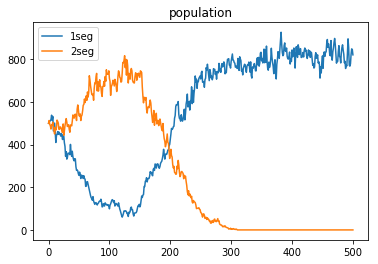

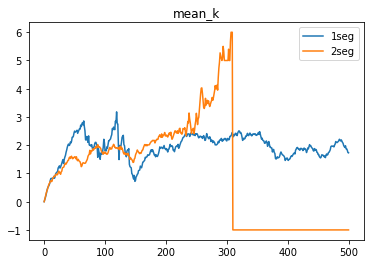

In [58]:
%matplotlib inline
import pandas
import matplotlib.pyplot as plt

# file_name = 'Influenza_comp_' + '' + '.csv'
data = pandas.read_csv(file_name)
plt.plot(data['pop1'], label='1seg')
plt.plot(data['pop2'], label='2seg')
plt.title('population')
plt.legend()
plt.show()

plt.plot(data['k1'], label='1seg')
plt.plot(data['k2'], label='2seg')
plt.legend()
plt.title('mean_k')
plt.show()